In [6]:
pip install pyet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from sklearn.linear_model import LinearRegression
from pyet.meteo_utils import extraterrestrial_r
from sklearn.metrics import r2_score,mean_squared_error

In [8]:
def get_number(string):
  number = ''
  for i in string:
    for j in range(48,58):
      if chr(j) == i:
        number += i
  return number

# Constantes para obtener Ra
DEG_TO_RAD_CONSTANT = 0.01745329251  
LAT = -33.3971255
lat_rad = float(LAT) *  DEG_TO_RAD_CONSTANT
# Cantidad de días de los reportes
horizon_const = 14
# Ruta
RUTA = '/content/drive/MyDrive/Universidad/et0 2022/data_processing/'
# Colores
colors = ['#D71BDD','#7C1BDD','#DD1B41','#46FF00','#61FF00','#80FF00','#9BFF00','#B9FF00','#F0FF00','#FFF000','#FFDC00','#FFC900','#FFBD00','#FFB200']

In [11]:
# Trabajando con los datasets de previsión climática
csv_files = glob.glob(RUTA+'forecast_data/*.csv')
csv_files.sort()

# 14 days horizon
date = []
t_min = []
t_max = []
rh_day = []
rh_night = []
wind_speed = []
sunshine_duration = []
weather_condition = []

horizon_days = []
et0_days = []


for i in range(horizon_const):
 date.append([])
 t_min.append([])
 t_max.append([])
 rh_day.append([])
 rh_night.append([])
 wind_speed.append([])
 sunshine_duration.append([])
 weather_condition.append([])


# Obtención de valores númericos 
for i in range (len(csv_files)):
  ds = pd.read_csv(csv_files[i])
  for h in range (horizon_const):
    t_min[h].append(float(get_number(ds.t_min[h])))
    t_max[h].append(float(get_number(ds.t_max[h])))
    rh_day[h].append(float(get_number(ds.humidity_day[h])))
    rh_night[h].append(float(get_number(ds.humidity_night[h])))
    wind_speed[h].append(float(get_number(ds.wind_speed[h])))
    sunshine_duration[h].append(ds.sunshine_duration[h])
    weather_condition[h].append(ds.weather_condition[h])
    date[h].append(pd.to_datetime(ds.date[h],format="%d-%m-%Y"))


# Conjunto de test 'Y' para Horizonte de 1 día de forecast
df_et0_test = pd.read_csv(RUTA+"data/et0_ref_test.csv")
df_et0_test.date = pd.to_datetime(df_et0_test.date,format="%d-%m-%Y")
df_et0_test = df_et0_test.set_index('date')
df_et0_test = df_et0_test[['et0']]

n_muestras = 26 # Cantidad de días en que se tiene el "et0 real" respecto a los reportes de la previsión climática a 14 días, a partir del 01-06-2022

# Creación de DataFrames para los 14 días de pronóstico # Indexando Fecha y añadiendo Ra complementaria
for i in range (horizon_const):
  horizon_days.append(pd.DataFrame({'date':date[i],'tmin':t_min[i],'tmax':t_max[i],'rhday':rh_day[i],'rhnight':rh_night[i],'wind':wind_speed[i],'ssh':sunshine_duration[i],'wc':weather_condition[i]}))
  horizon_days[i] = horizon_days[i].set_index('date')
  horizon_days[i]['ra'] = extraterrestrial_r(horizon_days[i].index,lat_rad)
  horizon_days[i] = horizon_days[i].iloc[0:n_muestras]
  et0_days.append(df_et0_test.iloc[i:i+n_muestras])

In [ ]:
# Descomposición del Dataset de datos Históricos

# Días hacia atrás
n_days = 30

dataset = pd.read_csv(RUTA+"data/Pudahuel01-01-2021--04-06-2022.csv")
dataset.date = pd.to_datetime(dataset.date,format="%Y-%m-%d")
X_tmean = dataset.iloc[-n_days:,5:6]
X_index = dataset.iloc[-n_days:,0]
X_temps = dataset.iloc[-n_days:,3:5]
X_ra = dataset.iloc[-n_days:,11:12]
X_rs = dataset.iloc[-n_days:,7]
y_index = X_index.copy()
y_et0 = dataset.iloc[-n_days:,10:11]
y = pd.concat([y_index,y_et0],axis=1)
y = y.set_index("date")

# Regresión Lineal Simple con ***X: Tmean*** ***y: Et0***

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
# División Training - Testing
X_train, X_test, y_train, y_test = train_test_split(X_tmean, y_et0, test_size = 0.2, shuffle = False)

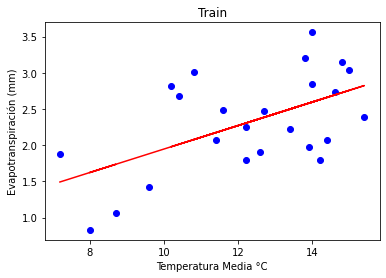

Coefficients: 
 [[0.16237489]]
Mean squared error: 0.31
Coefficient of determination: 0.31


In [ ]:
regression = LinearRegression()
regression.fit(X_train,y_train)
y_pred_test = regression.predict(X_test)
y_pred_train = regression.predict(X_train)

plt.scatter(X_train,y_train,color='blue')
plt.plot(X_train,regression.predict(X_train),color='red')
plt.title("Train")
plt.xlabel("Temperatura Media °C")
plt.ylabel("Evapotranspiración (mm)")

plt.show()


# The coefficients
print("Coefficients: \n", regression.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_train, y_pred_train))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_train, y_pred_train))

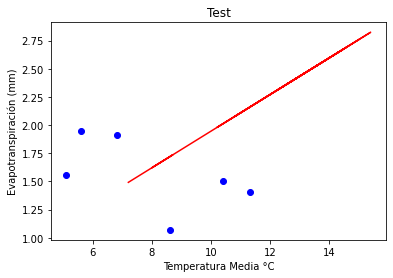

Coefficients: 
 [[0.16237489]]
Mean squared error: 0.36
Coefficient of determination: -2.99


In [ ]:
plt.scatter(X_test,y_test,color='blue')
plt.plot(X_train,regression.predict(X_train),color='red')
plt.title("Test")
plt.xlabel("Temperatura Media °C")
plt.ylabel("Evapotranspiración (mm)")

plt.show()

# The coefficients
print("Coefficients: \n", regression.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_test))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred_test))

Coefficient of determination: 0.78


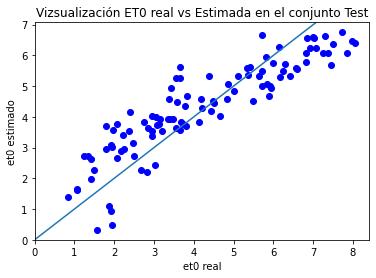

In [ ]:
plt.scatter(y_test, y_pred_test,color='blue')

plt.title('Vizsualización ET0 real vs Estimada en el conjunto Test')
plt.xlabel('et0 real')
plt.ylabel('et0 estimado')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
graph = plt.plot([-100, 100], [-100, 100])
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred_test))

# Regresión Lineal Múltiple con ***X1: Tmin, X2: Tmax, y: ET0***

In [ ]:
X = pd.concat([X_index,X_temps],axis = 1)
X = X.set_index("date")

In [ ]:
from sklearn.model_selection import train_test_split

# División Training - Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)
X_test_forecast_one = horizon_days[0][['tmin','tmax']]

In [ ]:
X_train = X.copy()
y_train = y.copy()
myvar = horizon_days[0][['tmin','tmax']]
X_test = myvar.iloc[0:20,:]
y_test = df_et0_test.iloc[0:20,:]


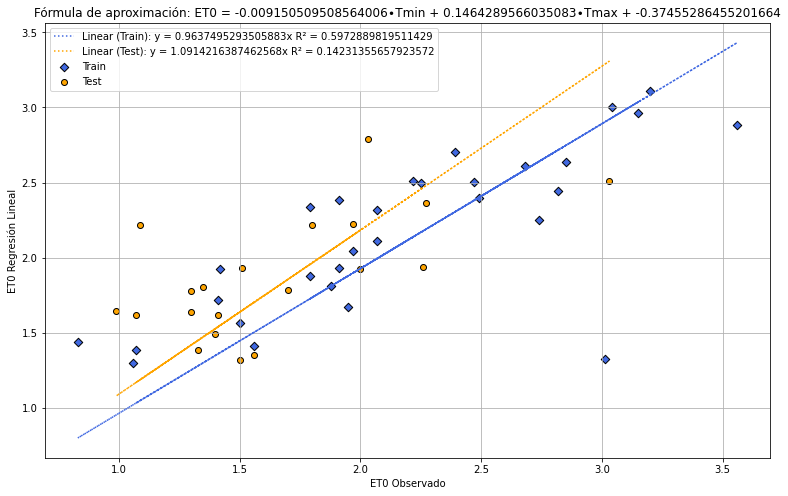

(             et0
date            
2022-06-01  1.56
2022-06-02  1.07
2022-06-03  1.50
2022-06-04  1.41
2022-06-05  2.26
2022-06-06  1.97
2022-06-07  1.80
2022-06-08  1.51
2022-06-09  1.09
2022-06-10  2.03
2022-06-11  3.03
2022-06-12  2.27
2022-06-13  1.30
2022-06-14  0.99
2022-06-15  1.30
2022-06-16  1.33
2022-06-17  1.35
2022-06-18  2.00
2022-06-19  1.70
2022-06-20  1.40, array([[1.35514309],
       [1.62054947],
       [1.31854105],
       [1.62054947],
       [1.94085891],
       [2.22456632],
       [2.21541581],
       [1.9317084 ],
       [2.21541581],
       [2.79198112],
       [2.50827372],
       [2.36184476],
       [1.63885049],
       [1.648001  ],
       [1.77612894],
       [1.38259461],
       [1.80358047],
       [1.92255789],
       [1.78527945],
       [1.49242153]]))


In [ ]:
from sklearn.linear_model import LinearRegression
regression = LinearRegression()
regression.fit(X_train,y_train)
y_pred_train = regression.predict(X_train)
y_pred_test = regression.predict(X_test)
y_pred_test_forecast = regression.predict(X_test_forecast_one)
# Creando Rectas para graficar train y test
regression_test = LinearRegression(fit_intercept=False)
regression_test.fit(y_test,y_pred_test)
regression_train = LinearRegression(fit_intercept=False)
regression_train.fit(y_train,y_pred_train)
# --------------------------------------------------------------
fig = plt.figure(figsize=(13,8))
# Grafico Rectas
plt.plot(y_train,regression_train.predict(y_train),color='royalblue',linestyle='dotted', label = 'Linear (Train): y = '+str(regression_train.coef_[0][0])+"x"+" R² = "+str(r2_score(y_train,y_pred_train)))
plt.plot(y_test,regression_test.predict(y_test),color='orange',linestyle='dotted',label = 'Linear (Test): y = '+str(regression_test.coef_[0][0])+"x"+" R² = "+str(r2_score(y_test,y_pred_test)))

# Puntos
plt.scatter(y_train,y_pred_train,color='royalblue',marker = 'D', edgecolor='black',label = 'Train')
plt.scatter(y_test,y_pred_test,color='orange',marker='o',edgecolor='black',label = 'Test')
# Fórmula
plt.title("Fórmula de aproximación: ET0 = "+str(regression.coef_[0][0])+"∙Tmin + "+str(regression.coef_[0][1])+"∙Tmax + "+str(regression.intercept_[0]))
# Ejes
plt.xlabel("ET0 Observado")
plt.ylabel("ET0 Regresión Lineal")
leg = plt.legend()
plt.grid()
plt.show()
print((y_test,y_pred_test))

# Perceptrón - Regresión Lineal Múltiple con ***X1: Tmin, X2: Tmax, y: ET0***

In [ ]:
# Librerías 
import tensorflow as tf
import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error

In [ ]:
X = pd.concat([X_index,X_temps],axis = 1)
X = X.set_index("date")

# Temperaturas Forecast
X_test_forecast_one = horizon_days[0][['tmin','tmax']]
X_test_forecast_5 = horizon_days[4][['tmin','tmax']]
X_test_forecast_7 = horizon_days[6][['tmin','tmax']]

In [ ]:
# División Training - Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

# Definición del Modelo
model = keras.Sequential([
    layers.Dense(1, input_shape=(2,))
])

optimizer = tf.keras.optimizers.RMSprop(0.001)
# optimizer = tf.keras.optimizers.SGD(0.001)

model.compile(
    loss='mse',
    optimizer=optimizer,
    metrics=["mse","mae"],
)

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000
# Entrenamiento
history = model.fit(X_train, y_train, epochs=EPOCHS)

Epoch 1/1000
13/13 [==============================] - 1s 2ms/step - loss: 14.8993 - mse: 14.8993 - mae: 3.0811
Epoch 2/1000
13/13 [==============================] - 0s 995us/step - loss: 13.0814 - mse: 13.0814 - mae: 2.8688
Epoch 3/1000
13/13 [==============================] - 0s 914us/step - loss: 11.9864 - mse: 11.9864 - mae: 2.7726
Epoch 4/1000
13/13 [==============================] - 0s 914us/step - loss: 11.2629 - mse: 11.2629 - mae: 2.7159
Epoch 5/1000
13/13 [==============================] - 0s 831us/step - loss: 10.7419 - mse: 10.7419 - mae: 2.6755
Epoch 6/1000
13/13 [==============================] - 0s 917us/step - loss: 10.3148 - mse: 10.3148 - mae: 2.6424
Epoch 7/1000
13/13 [==============================] - 0s 914us/step - loss: 9.9466 - mse: 9.9466 - mae: 2.6110
Epoch 8/1000
13/13 [==============================] - 0s 914us/step - loss: 9.6172 - mse: 9.6172 - mae: 2.5843
Epoch 9/1000
13/13 [==============================] - 0s 997us/step - loss: 9.3076 - mse: 9.3076 - mae

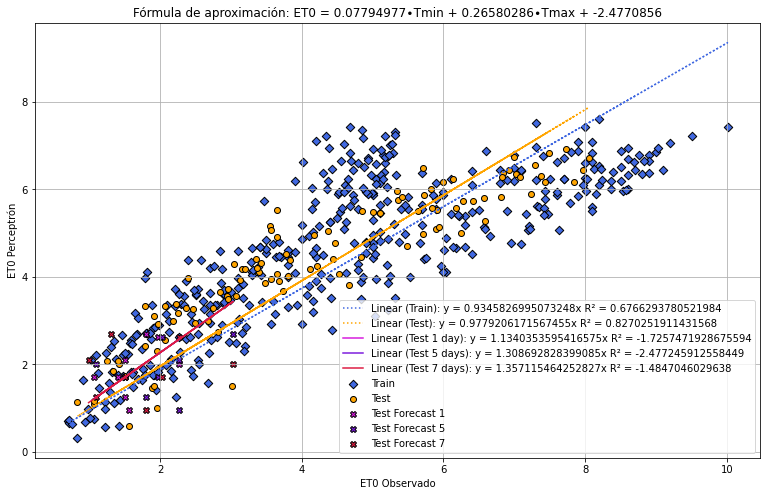

Train
 MAE:  1.0518102645874023 MSE:  1.6116582155227661
Test
 MAE:  0.7038881256030157 MSE:  0.6728139980811658
0.010874964826360078


In [ ]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
y_pred_test_forecast = model.predict(X_test_forecast_one)
y_pred_test_forecast_5 = model.predict(X_test_forecast_5)
y_pred_test_forecast_7 = model.predict(X_test_forecast_7)

# Creando Rectas para graficar train y test
regression_test = LinearRegression(fit_intercept=False)
regression_test.fit(y_test,y_pred_test)
regression_train = LinearRegression(fit_intercept=False)
regression_train.fit(y_train,y_pred_train)

regression_test_forecast_one = LinearRegression(fit_intercept=False)
regression_test_forecast_one.fit(et0_days[0],y_pred_test_forecast)
regression_test_forecast_5 = LinearRegression(fit_intercept=False)
regression_test_forecast_5.fit(et0_days[4],y_pred_test_forecast_5)
regression_test_forecast_7 = LinearRegression(fit_intercept=False)
regression_test_forecast_7.fit(et0_days[6],y_pred_test_forecast_7)

fig = plt.figure(figsize=(13,8))
# Gráfico Rectas
plt.plot(y_train,regression_train.predict(y_train),color='royalblue',linestyle='dotted', label = 'Linear (Train): y = '+str(regression_train.coef_[0][0])+"x"+" R² = "+str(r2_score(y_train,y_pred_train)))
plt.plot(y_test,regression_test.predict(y_test),color='orange',linestyle='dotted',label = 'Linear (Test): y = '+str(regression_test.coef_[0][0])+"x"+" R² = "+str(r2_score(y_test,y_pred_test)))

plt.plot(et0_days[0],regression_test_forecast_one.predict(et0_days[0]),color=colors[0],label = 'Linear (Test 1 day): y = '+str(regression_test_forecast_one.coef_[0][0])+"x"+" R² = "+str(r2_score(et0_days[0],y_pred_test_forecast)))
plt.plot(et0_days[4],regression_test_forecast_one.predict(et0_days[4]),color=colors[1],label = 'Linear (Test 5 days): y = '+str(regression_test_forecast_5.coef_[0][0])+"x"+" R² = "+str(r2_score(et0_days[4],y_pred_test_forecast_5)))
plt.plot(et0_days[6],regression_test_forecast_one.predict(et0_days[6]),color=colors[2],label = 'Linear (Test 7 days): y = '+str(regression_test_forecast_7.coef_[0][0])+"x"+" R² = "+str(r2_score(et0_days[6],y_pred_test_forecast_7)))

# Puntos
plt.scatter(y_train,y_pred_train,color='royalblue',marker = 'D', edgecolor='black',label = 'Train')
plt.scatter(y_test,y_pred_test,color='orange',marker='o',edgecolor='black',label = 'Test')

plt.scatter(et0_days[0],y_pred_test_forecast,color=colors[0],marker='X',edgecolor='black',label = 'Test Forecast 1')
plt.scatter(et0_days[4],y_pred_test_forecast,color=colors[1],marker='X',edgecolor='black',label = 'Test Forecast 5')
plt.scatter(et0_days[6],y_pred_test_forecast,color=colors[2],marker='X',edgecolor='black',label = 'Test Forecast 7')
# Pesos e Intercepto
w1 = history.model.get_weights()[0][0][0]
w2 = history.model.get_weights()[0][1][0]
# w3 = history.model.get_weights()[0][2][0]
intercept = history.model.get_weights()[1][0]


# Fórmula
plt.title("Fórmula de aproximación: ET0 = "+str(w1)+"∙Tmin + "+str(w2)+"∙Tmax + "+str(intercept))


# Ejes
plt.xlabel("ET0 Observado")
plt.ylabel("ET0 Perceptrón")

leg = plt.legend()
plt.grid()
plt.show()

# Métricas
mae_ = history.history['mae'][-1]
mse_ = history.history['mse'][-1]
print ('Train\n MAE: ',mae_,'MSE: ',mse_)
print ('Test\n MAE: ',np.mean(np.absolute(y_pred_test - y_test).et0),'MSE: ',np.mean((y_pred_test - y_test).et0 ** 2))

print(r2_score(y_pred_test_forecast,et0_days[0]))

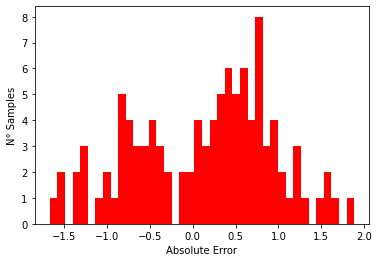

In [ ]:
error = y_pred_test - y_test
plt.hist(error.et0, bins = 40,color='red')
plt.xlabel("Absolute Error")
_ = plt.ylabel("N° Samples")

Text(0, 0.5, 'MSE')

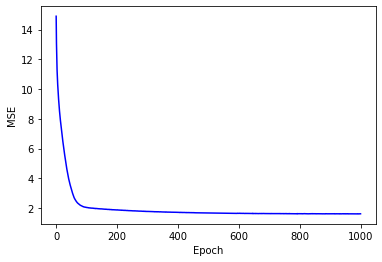

In [ ]:
plt.plot(history.history['mse'][:], color="b")
plt.xlabel("Epoch")
plt.ylabel("MSE")

# Perceptrón - Regresión Lineal Múltiple con ***X1: Tmin, X2: Tmax, X3: Ra, y: ET0***

In [ ]:
# Librerías 
import tensorflow as tf
import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error

In [ ]:
X = pd.concat([X_index,X_temps,X_ra],axis = 1)
X = X.set_index("date")
X_test_forecast_one = horizon_days[0][['tmin','tmax','ra']]
X_test_forecast_5 = horizon_days[4][['tmin','tmax','ra']]
X_test_forecast_7 = horizon_days[6][['tmin','tmax','ra']]

In [ ]:
# División Training - Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle =False)

# Definición del Modelo
model = keras.Sequential([
    layers.Dense(1, input_shape=(3,))
])

optimizer = tf.keras.optimizers.RMSprop(0.001)
# optimizer = tf.keras.optimizers.SGD(0.001)

model.compile(
    loss='mse',
    optimizer=optimizer,
    metrics=["mse","mae"],
)

In [ ]:
X_train = X.copy()
y_train = y.copy()
myvar = horizon_days[0][['tmin','tmax']]
myvar['ra'] = extraterrestrial_r(myvar.index,lat_rad)
X_test = myvar.iloc[0:20,:]
y_test = df_et0_test.iloc[0:20,:]
y_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,et0
date,
2022-06-01,1.56
2022-06-02,1.07
2022-06-03,1.50
2022-06-04,1.41
2022-06-05,2.26
2022-06-06,1.97
2022-06-07,1.80
2022-06-08,1.51
2022-06-09,1.09


In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000
# Entrenamiento
history = model.fit(X_train, y_train, epochs=EPOCHS)

Epoch 1/1000
1/1 [==============================] - 0s 454ms/step - loss: 856.1635 - mse: 856.1635 - mae: 28.9642
Epoch 2/1000
1/1 [==============================] - 0s 6ms/step - loss: 848.1832 - mse: 848.1832 - mae: 28.8291
Epoch 3/1000
1/1 [==============================] - 0s 8ms/step - loss: 842.4297 - mse: 842.4297 - mae: 28.7313
Epoch 4/1000
1/1 [==============================] - 0s 6ms/step - loss: 837.6337 - mse: 837.6337 - mae: 28.6495
Epoch 5/1000
1/1 [==============================] - 0s 9ms/step - loss: 833.3919 - mse: 833.3919 - mae: 28.5770
Epoch 6/1000
1/1 [==============================] - 0s 9ms/step - loss: 829.5176 - mse: 829.5176 - mae: 28.5106
Epoch 7/1000
1/1 [==============================] - 0s 8ms/step - loss: 825.9061 - mse: 825.9061 - mae: 28.4485
Epoch 8/1000
1/1 [==============================] - 0s 6ms/step - loss: 822.4930 - mse: 822.4930 - mae: 28.3898
Epoch 9/1000
1/1 [==============================] - 0s 8ms/step - loss: 819.2346 - mse: 819.2346 - mae

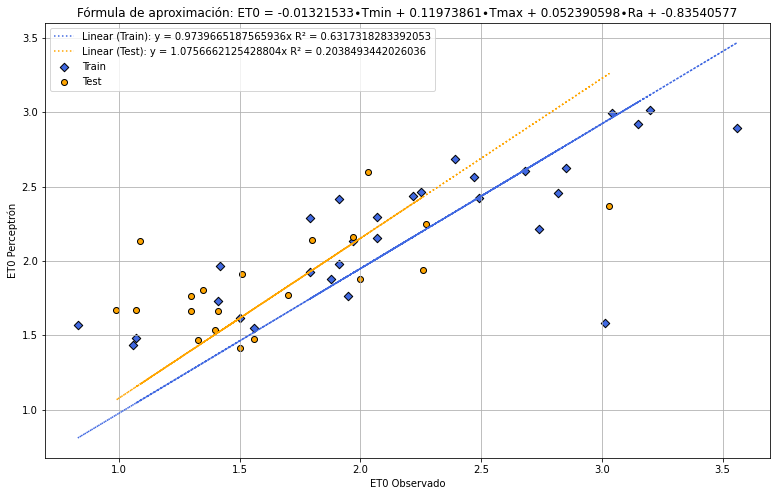

Train
 MAE:  0.2944084703922272 MSE:  0.17136985063552856
Test
 MAE:  0.3499627647399902 MSE:  0.1889924320874894
(             et0
date            
2022-06-01  1.56
2022-06-02  1.07
2022-06-03  1.50
2022-06-04  1.41
2022-06-05  2.26
2022-06-06  1.97
2022-06-07  1.80
2022-06-08  1.51
2022-06-09  1.09
2022-06-10  2.03
2022-06-11  3.03
2022-06-12  2.27
2022-06-13  1.30
2022-06-14  0.99
2022-06-15  1.30
2022-06-16  1.33
2022-06-17  1.35
2022-06-18  2.00
2022-06-19  1.70
2022-06-20  1.40, array([[1.4739323],
       [1.6692185],
       [1.4122031],
       [1.6607962],
       [1.9360442],
       [2.1586561],
       [2.142017 ],
       [1.9125576],
       [2.1358497],
       [2.5988472],
       [2.3700721],
       [2.24805  ],
       [1.6605179],
       [1.6719093],
       [1.7636237],
       [1.4691217],
       [1.800775 ],
       [1.8799672],
       [1.7727747],
       [1.5328596]], dtype=float32))


In [ ]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Et0 Estimado a partir de variables de Forecast
# y_pred_test_forecast = model.predict(X_test_forecast_one)
# y_pred_test_forecast_5 = model.predict(X_test_forecast_5)
# y_pred_test_forecast_7 = model.predict(X_test_forecast_7)

# Creando Rectas para graficar train y test
regression_test = LinearRegression(fit_intercept=False)
regression_test.fit(y_test,y_pred_test)
regression_train = LinearRegression(fit_intercept=False)
regression_train.fit(y_train,y_pred_train)

# regression_test_forecast_one = LinearRegression(fit_intercept=False)
# regression_test_forecast_one.fit(et0_days[0],y_pred_test_forecast)
# regression_test_forecast_5 = LinearRegression(fit_intercept=False)
# regression_test_forecast_5.fit(et0_days[4],y_pred_test_forecast_5)
# regression_test_forecast_7 = LinearRegression(fit_intercept=False)
# regression_test_forecast_7.fit(et0_days[6],y_pred_test_forecast_7)

fig = plt.figure(figsize=(13,8))
# Gráfico Rectas
plt.plot(y_train,regression_train.predict(y_train),color='royalblue',linestyle='dotted', label = 'Linear (Train): y = '+str(regression_train.coef_[0][0])+"x"+" R² = "+str(r2_score(y_train,y_pred_train)))
plt.plot(y_test,regression_test.predict(y_test),color='orange',linestyle='dotted',label = 'Linear (Test): y = '+str(regression_test.coef_[0][0])+"x"+" R² = "+str(r2_score(y_test,y_pred_test)))

# plt.plot(et0_days[0],regression_test_forecast_one.predict(et0_days[0]),color='red',label = 'Linear (Test 1 day): y = '+str(regression_test_forecast_one.coef_[0][0])+"x"+" R² = "+str(r2_score(et0_days[0],y_pred_test_forecast)))
# plt.plot(et0_days[4],regression_test_forecast_5.predict(et0_days[4]),color=colors[0],label = 'Linear (Test 5 day): y = '+str(regression_test_forecast_5.coef_[0][0])+"x"+" R² = "+str(r2_score(et0_days[4],y_pred_test_forecast_5)))
# plt.plot(et0_days[6],regression_test_forecast_7.predict(et0_days[6]),color=colors[1],label = 'Linear (Test 7 day): y = '+str(regression_test_forecast_7.coef_[0][0])+"x"+" R² = "+str(r2_score(et0_days[6],y_pred_test_forecast_7)))
# Puntos
plt.scatter(y_train,y_pred_train,color='royalblue',marker = 'D', edgecolor='black',label = 'Train')
plt.scatter(y_test,y_pred_test,color='orange',marker='o',edgecolor='black',label = 'Test')

# plt.scatter(et0_days[0],y_pred_test_forecast,color='orangered',marker='X',edgecolor='black',label = 'Test Forecast')
# plt.scatter(et0_days[4],y_pred_test_forecast_5,color=colors[0],marker='X',edgecolor='black',label = 'Test Forecast 5')
# plt.scatter(et0_days[6],y_pred_test_forecast_7,color=colors[1],marker='X',edgecolor='black',label = 'Test Forecast 7')
# Pesos e Intercepto
w1 = history.model.get_weights()[0][0][0]
w2 = history.model.get_weights()[0][1][0]
w3 = history.model.get_weights()[0][2][0]
intercept = history.model.get_weights()[1][0]


# Fórmula
plt.title("Fórmula de aproximación: ET0 = "+str(w1)+"∙Tmin + "+str(w2)+"∙Tmax + "+str(w3)+"∙Ra + "+str(intercept))


# Ejes
plt.xlabel("ET0 Observado")
plt.ylabel("ET0 Perceptrón")

leg = plt.legend()
plt.grid()
plt.show()

# Métricas
mae_ = history.history['mae'][-1]
mse_ = history.history['mse'][-1]
print ('Train\n MAE: ',mae_,'MSE: ',mse_)
print ('Test\n MAE: ',np.mean(np.absolute(y_pred_test - y_test).et0),'MSE: ',np.mean((y_pred_test - y_test).et0 ** 2))
print((y_test,y_pred_test))

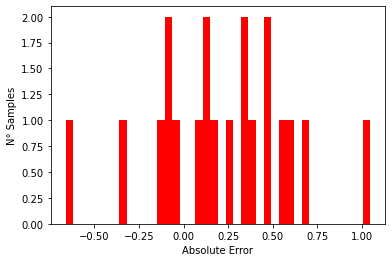

In [ ]:
error = y_pred_test - y_test
plt.hist(error.et0, bins = 40,color='red')
plt.xlabel("Absolute Error")
_ = plt.ylabel("N° Samples")

Text(0, 0.5, 'MSE')

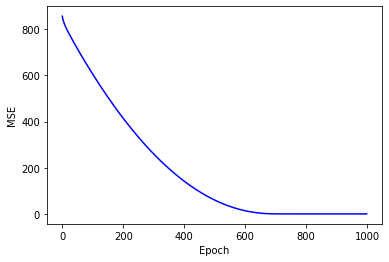

In [ ]:
plt.plot(history.history['mse'][:], color="b")
plt.xlabel("Epoch")
plt.ylabel("MSE")

# Perceptrón - Regresión Lineal Múltiple con ***X1: Tmin, X2: Tmax, X3: Rs, y: ET0***

In [ ]:
# Librerías 
import tensorflow as tf
import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error

In [ ]:
X = pd.concat([X_index,X_temps,X_rs],axis = 1)
X = X.set_index("date")


In [ ]:
# División Training - Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=False)

# Definición del Modelo
model = keras.Sequential([
    layers.Dense(1, input_shape=(3,))
])

optimizer = tf.keras.optimizers.RMSprop(0.001)
# optimizer = tf.keras.optimizers.SGD(0.001)

model.compile(
    loss='mse',
    optimizer=optimizer,
    metrics=["mse","mae"],
)


In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000
# Entrenamiento
history = model.fit(X_train, y_train, epochs=EPOCHS)

Epoch 1/1000
13/13 [==============================] - 1s 3ms/step - loss: 22.6559 - mse: 22.6559 - mae: 4.0990
Epoch 2/1000
13/13 [==============================] - 0s 3ms/step - loss: 17.2049 - mse: 17.2049 - mae: 3.4949
Epoch 3/1000
13/13 [==============================] - 0s 2ms/step - loss: 13.9405 - mse: 13.9405 - mae: 3.1121
Epoch 4/1000
13/13 [==============================] - 0s 4ms/step - loss: 11.7719 - mse: 11.7719 - mae: 2.8372
Epoch 5/1000
13/13 [==============================] - 0s 3ms/step - loss: 10.4373 - mse: 10.4373 - mae: 2.6615
Epoch 6/1000
13/13 [==============================] - 0s 3ms/step - loss: 9.7316 - mse: 9.7316 - mae: 2.5671
Epoch 7/1000
13/13 [==============================] - 0s 4ms/step - loss: 9.3403 - mse: 9.3403 - mae: 2.5129
Epoch 8/1000
13/13 [==============================] - 0s 4ms/step - loss: 9.0808 - mse: 9.0808 - mae: 2.4746
Epoch 9/1000
13/13 [==============================] - 0s 3ms/step - loss: 8.8519 - mse: 8.8519 - mae: 2.4390
Epoch 10/

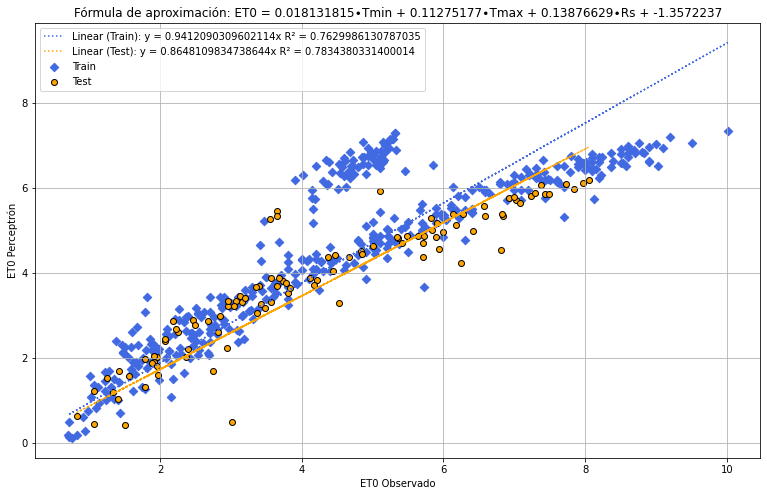

Train
 MAE:  0.8344196677207947 MSE:  1.1779166460037231
Test
 MAE:  0.6982047683000565 MSE:  0.8423534254400317


In [ ]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)


# Creando Rectas para graficar train y test
regression_test = LinearRegression(fit_intercept=False)
regression_test.fit(y_test,y_pred_test)
regression_train = LinearRegression(fit_intercept=False)
regression_train.fit(y_train,y_pred_train)


fig = plt.figure(figsize=(13,8))
# Gráfico Rectas
plt.plot(y_train,regression_train.predict(y_train),color='royalblue',linestyle='dotted', label = 'Linear (Train): y = '+str(regression_train.coef_[0][0])+"x"+" R² = "+str(r2_score(y_train,y_pred_train)))
plt.plot(y_test,regression_test.predict(y_test),color='orange',linestyle='dotted',label = 'Linear (Test): y = '+str(regression_test.coef_[0][0])+"x"+" R² = "+str(r2_score(y_test,y_pred_test)))


# Puntos
plt.scatter(y_train,y_pred_train,color='royalblue',marker = 'D',label = 'Train')
plt.scatter(y_test,y_pred_test,color='orange',marker='o',edgecolor='black',label = 'Test')


# Pesos e Intercepto
w1 = history.model.get_weights()[0][0][0]
w2 = history.model.get_weights()[0][1][0]
w3 = history.model.get_weights()[0][2][0]
intercept = history.model.get_weights()[1][0]


# Fórmula
plt.title("Fórmula de aproximación: ET0 = "+str(w1)+"∙Tmin + "+str(w2)+"∙Tmax + "+str(w3)+"∙Rs + "+str(intercept))


# Ejes
plt.xlabel("ET0 Observado")
plt.ylabel("ET0 Perceptrón")

leg = plt.legend()
plt.grid()
plt.show()

# Métricas
mae_ = history.history['mae'][-1]
mse_ = history.history['mse'][-1]
print ('Train\n MAE: ',mae_,'MSE: ',mse_)
print ('Test\n MAE: ',np.mean(np.absolute(y_pred_test - y_test).et0),'MSE: ',np.mean((y_pred_test - y_test).et0 ** 2))

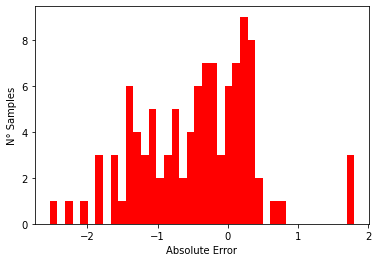

In [ ]:
error = y_pred_test - y_test
plt.hist(error.et0, bins = 40,color='red')
plt.xlabel("Absolute Error")
_ = plt.ylabel("N° Samples")

Text(0, 0.5, 'MSE')

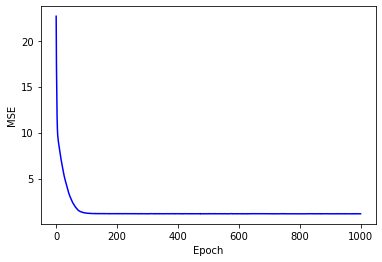

In [ ]:
plt.plot(history.history['mse'][:], color="b")
plt.xlabel("Epoch")
plt.ylabel("MSE")